In [1]:
import sys

sys.path.append("../")

In [2]:
from copy import deepcopy
from datetime import datetime

import gymnasium as gym
import numpy as np
from gymnasium.wrappers import FlattenObservation, RecordVideo, RescaleAction, TimeLimit
from stable_baselines3 import SAC

from src.ea_optimize import OptimizeFunctionCallback, setup_callback
from src.environments import bc, ea
from src.wrappers import LatticeAgnosticCompatibility, ReorderMagnets, RecordEpisode
from src.utils import (
    ARESeLog,
    NotVecNormalize,
    PolishedDonkeyCompatibility,
    TQDMWrapper,
)

In [3]:
def optimize_copper_ea(
    max_steps=50,
    model_name="still-durian-82",
    logbook=False,
    data_log_dir=None,
    progress_bar=False,
    callback=None,
):
    """
    Function used for optimisation during operation.

    Note: Current version only works for polished-donkey-996.
    """
    # config = read_from_yaml(f"models/{model}/config")
    # assert (
    #     model_name == "copper-planet-90"
    # ), "Current version only works for polished-donkey-996."

    # Load the model
    model = SAC.load(f"../models/larl/{model_name}/model")

    callback = setup_callback(callback)

    # Create the environment
    env = ea.TransverseTuning(
        backend="doocs_dummy",  # TODO: Change to "doocs" once DOOCS backend is ready
        action_mode="delta",
        magnet_init_mode="random",  # TODO Should be None
        max_quad_delta=72 * 0.1,
        max_steerer_delta=6.1782e-3 * 0.1,
        target_beam_mode=np.zeros(4),  # still-durian-82 can only handle one beam
        target_threshold=2e-5,  # 2e-5 is the estimated accuracy of the screen
        unidirectional_quads=True,
    )
    if max_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_steps)
    if progress_bar:
        env = TQDMWrapper(env)
    if callback is not None:
        env = OptimizeFunctionCallback(env, callback)
    if data_log_dir is not None:
        env = RecordEpisode(env, save_dir=data_log_dir)
    if logbook:
        env = ARESeLog(env, model_name=model_name)
    # env = RecordVideo(env, f"recordings_real/{datetime.now():%Y%m%d%H%M}")
    env = FlattenObservation(env)
    env = LatticeAgnosticCompatibility(env, order="ea")
    env = RescaleAction(env, -1, 1)

    callback.env = env

    # Actual optimisation
    observation, info = env.reset()
    done = False
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    env.close()

In [1]:
ea.pydoocs.dummy.dummy.segment.AREABSCR1.is_active = True

NameError: name 'ea' is not defined

/home/kaiserja/.conda/envs/ares-transverse-tuning/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(
100%|██████████| 3/3 [00:21<00:00,  7.23s/it]


title = 'Beam Optimisation on AREABSCR1 using Reinforcement Learning'
msg = 'Reinforcement Learning agent optimised beam on AREABSCR1\n\nAgent: still-durian-82\nStart time: 2023-06-29 15:33:30.664939\nTime taken: 0:00:21.683132\nNo. of steps: 3\n\nBeam before:\n    mu_x    = -0.0018 mm\n    sigma_x =  3.6874 mm\n    mu_y    =  0.0013 mm\n    sigma_y =  2.1648 mm\n\nBeam after:\n    mu_x    = -0.0018 mm\n    sigma_x =  3.6874 mm\n    mu_y    =  0.0013 mm\n    sigma_y =  2.1648 mm\n\nTarget beam:\n    mu_x    =  0.0000 mm    (e = 0.0200 mm) ;)\n    sigma_x =  0.0000 mm    (e = 0.0200 mm) :/\n    mu_y    =  0.0000 mm    (e = 0.0200 mm) ;)\n    sigma_y =  0.0000 mm    (e = 0.0200 mm) :/\n\nResult:\n    |delta_mu_x|    =  0.0018 mm\n    |delta_sigma_x| =  3.6874 mm\n    |delta_mu_y|    =  0.0013 mm\n    |delta_sigma_y| =  2.1648 mm\n\n    MAE =  1.4638 mm\n\nFinal magnet settings:\n    AREAMQZM1 strength =  30.7569 1/m^2\n    AREAMQZM2 strength = -53.8915 1/m^2\n    AREAMCVM1 kick     =  -4

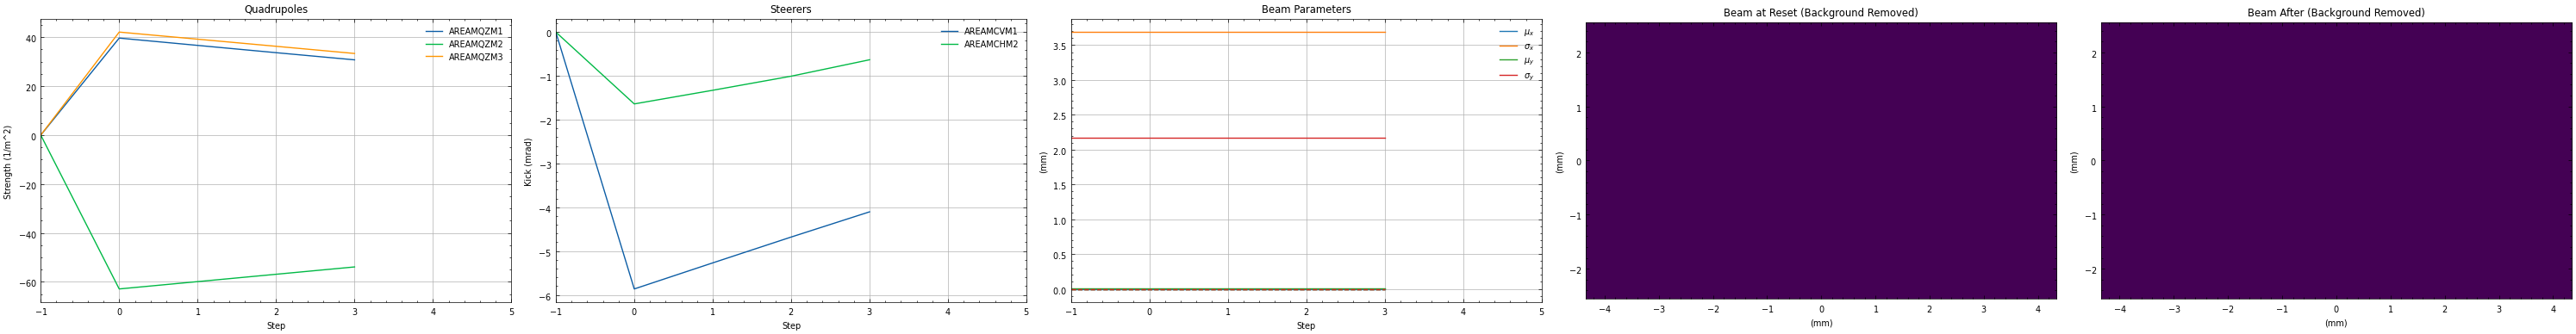

In [4]:
optimize_copper_ea(progress_bar=True, logbook=True, max_steps=3)

In [5]:
def optimize_copper_bc(
    max_steps=50,
    model_name="still-durian-82",
    logbook=False,
    data_log_dir=None,
    progress_bar=False,
    callback=None,
):
    """
    Function used for optimisation during operation.

    Note: Current version only works for polished-donkey-996.
    """
    # config = read_from_yaml(f"models/{model}/config")
    # assert (
    #     model_name == "copper-planet-90"
    # ), "Current version only works for polished-donkey-996."

    # Load the model
    model = SAC.load(f"../models/larl/{model_name}/model")

    callback = setup_callback(callback)

    # Create the environment
    env = bc.TransverseTuning(
        backend="doocs_dummy",  # TODO: Change to "doocs" once DOOCS backend is ready
        action_mode="delta",
        magnet_init_mode="random",  # TODO Should be None
        max_quad_delta=72 * 0.1,
        max_steerer_delta=6.1782e-3 * 0.1,
        target_beam_mode=np.zeros(4),  # still-durian-82 can only handle one beam
        target_threshold=2e-5,  # 2e-5 is the estimated accuracy of the screen
        unidirectional_quads=True,
        normalize_beam_distance=False,
    )
    if max_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_steps)
    if progress_bar:
        env = TQDMWrapper(env)
    if callback is not None:
        env = OptimizeFunctionCallback(env, callback)
    if data_log_dir is not None:
        env = RecordEpisode(env, save_dir=data_log_dir)
    if logbook:
        env = ARESeLog(env, model_name=model_name)
    # env = RecordVideo(env, f"recordings_real/{datetime.now():%Y%m%d%H%M}")
    env = FlattenObservation(env)
    env = LatticeAgnosticCompatibility(env, order="bc")
    env = RescaleAction(env, -1, 1)

    callback.env = env

    # Actual optimisation
    observation, info = env.reset()
    done = False
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    env.close()

In [ ]:
ea.pydoocs.dummy.dummy.segment.AREABSCR1.is_active = False
ea.pydoocs.dummy.dummy.segment.ARBCBSCE1.is_active = True

In [ ]:
from cheetah import Screen

for element in ea.pydoocs.dummy.dummy.segment.elements:
    if isinstance(element, Screen):
        print(f"{element.name}: {element.is_active = }")

ARLIBSCL1: element.is_active = False
ARLIBSCX1: element.is_active = False
ARLIBSCR1: element.is_active = False
ARLIBSCR2: element.is_active = False
ARLIBSCR3: element.is_active = False
AREABSCR1: element.is_active = False
ARMRBSCR1: element.is_active = False
ARMRBSCR2: element.is_active = False
ARMRBSCR3: element.is_active = False
ARBCBSCE1: element.is_active = True
ARDLBSCR1: element.is_active = False
ARDLBSCE1: element.is_active = False
ARSHBSCE2: element.is_active = False
ARSHBSCE1: element.is_active = False


100%|██████████| 50/50 [05:44<00:00,  6.88s/it]


title = 'Beam Optimisation on AREABSCR1 using Reinforcement Learning'
msg = 'Reinforcement Learning agent optimised beam on AREABSCR1\n\nAgent: still-durian-82\nStart time: 2023-06-22 17:35:53.563039\nTime taken: 0:05:44.164925\nNo. of steps: 50\n\nBeam before:\n    mu_x    = -0.0018 mm\n    sigma_x =  3.6874 mm\n    mu_y    =  0.0013 mm\n    sigma_y =  2.1648 mm\n\nBeam after:\n    mu_x    = -0.0018 mm\n    sigma_x =  3.6874 mm\n    mu_y    =  0.0013 mm\n    sigma_y =  2.1648 mm\n\nTarget beam:\n    mu_x    =  0.0000 mm    (e = 0.0200 mm) ;)\n    sigma_x =  0.0000 mm    (e = 0.0200 mm) :/\n    mu_y    =  0.0000 mm    (e = 0.0200 mm) ;)\n    sigma_y =  0.0000 mm    (e = 0.0200 mm) :/\n\nResult:\n    |delta_mu_x|    =  0.0018 mm\n    |delta_sigma_x| =  3.6874 mm\n    |delta_mu_y|    =  0.0013 mm\n    |delta_sigma_y| =  2.1648 mm\n\n    MAE =  1.4638 mm\n\nFinal magnet settings:\n    AREAMQZM1 strength =  12.5443 1/m^2\n    AREAMQZM2 strength = -18.1962 1/m^2\n    AREAMCVM1 kick     =   

/usr/bin/lp: No such file or directory


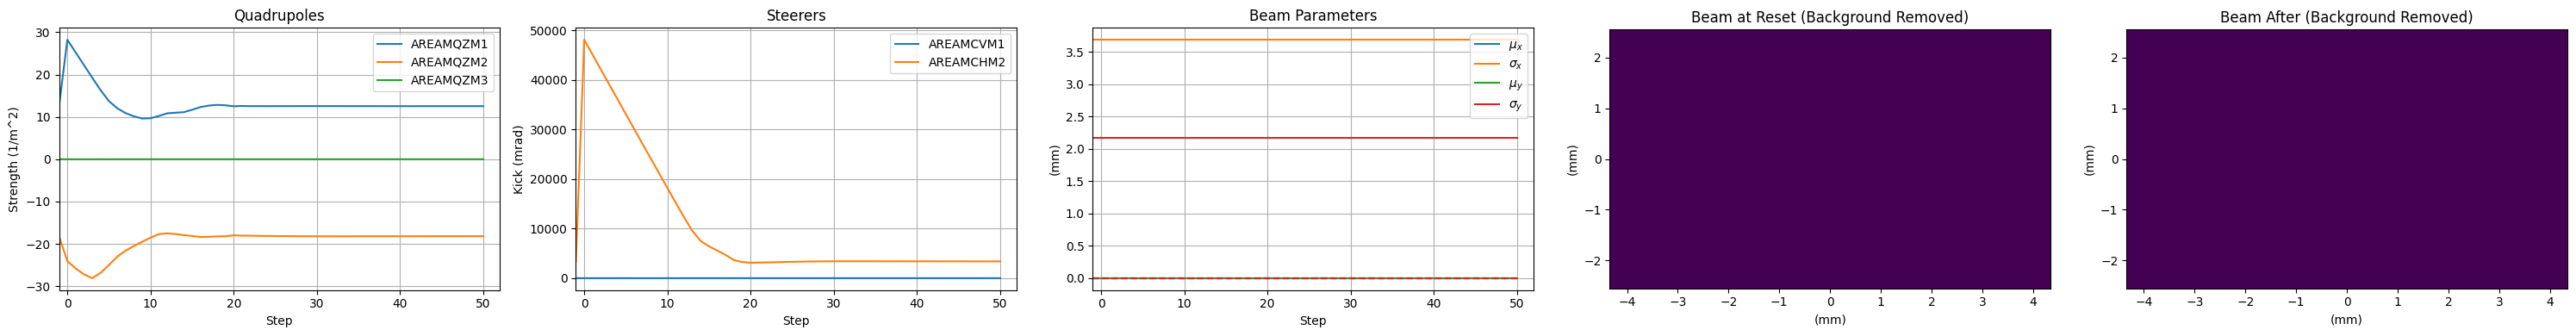

In [ ]:
optimize_copper_bc(progress_bar=True, logbook=True, max_steps=50)